In [661]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [662]:
path = 'images\demo6.jpg'

In [663]:
def show(img, title = 'Gray Image', gray = False, fs = 15, dp = (10, 10)):
    plt.rcParams.update({'font.size': fs})
    plt.rcParams['figure.figsize'] = dp
    if gray:
        plt.imshow(img, cmap=plt.cm.gray)
    else:
        plt.imshow(img[:,:,::-1])
    plt.axis('off')
    plt.title(f'{title}')
    plt.show()
    
def show2(img1, img2, title1 = 'Image 1', title2 = 'Image 2', gray = False, fs = 15, dp = (10, 10)):
    plt.rcParams.update({'font.size': fs})
    plt.rcParams['figure.figsize'] = dp
    plt.subplot(121)
    if gray:
        plt.imshow(img1, cmap=plt.cm.gray)
    else:
        plt.imshow(img1[:,:,::-1])
    plt.axis('off')
    plt.title(f'{title1}')
    plt.subplot(122)
    if gray:
        plt.imshow(img2, cmap=plt.cm.gray)
    else:
        plt.imshow(img2[:,:,::-1])
    plt.axis('off')
    plt.title(f'{title2}')
    plt.show()

## Load ảnh

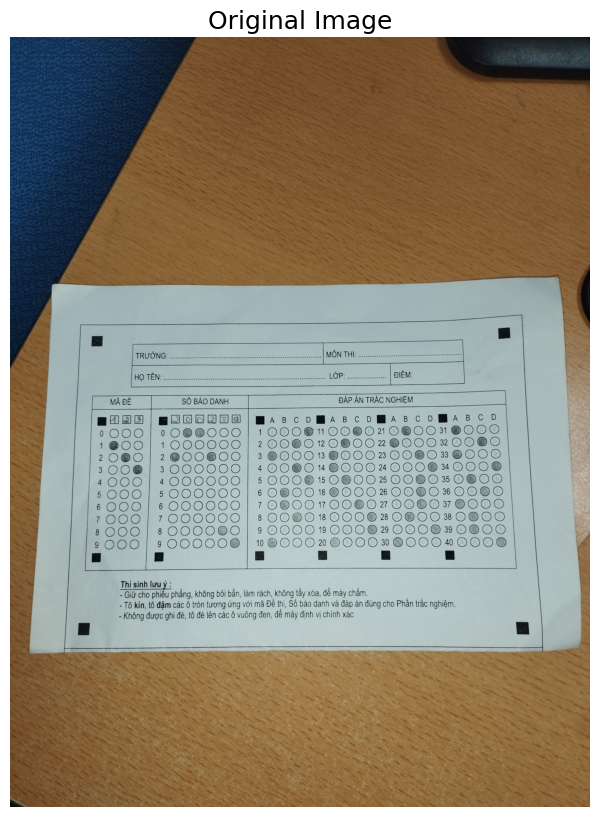

In [664]:
image = cv2.imread(path)
show(image, 'Original Image')

## Convert ảnh sang gray và làm mịn

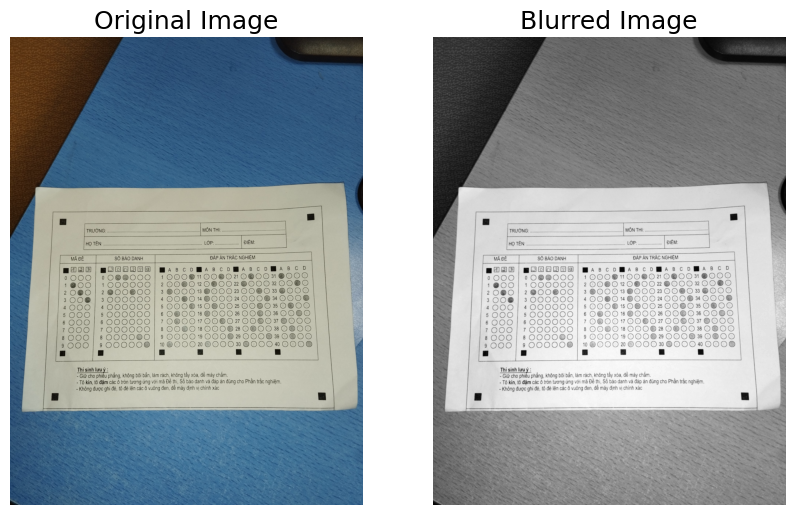

In [665]:
def cvt2gray_blur(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    return img

blur = cvt2gray_blur(image)
show2(image, blur, 'Original Image', 'Blurred Image', gray = True)

## Cắt phần giấy làm bài

In [666]:
def get_edges(img):
    edges = cv2.Canny(img, 100, 200)
    return edges

def get_contours(img):
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def get_thresh(img):
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 3)
    return thresh

def draw_contours(img, contours):
    img = cv2.drawContours(img, contours, -1, (0, 255, 0), 2)
    return img
def get_area(contour):
    return cv2.contourArea(contour)

In [667]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0], rect[2] = pts[np.argmin(s)], pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1], rect[3] = pts[np.argmin(diff)], pts[np.argmax(diff)]

    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    maxWidth = max(np.linalg.norm(br - bl), np.linalg.norm(tr - tl))
    maxHeight = max(np.linalg.norm(tr - br), np.linalg.norm(tl - bl))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (int(maxWidth), int(maxHeight)))
    return warped

def find_corner_by_rotated_rect(box, approx):
    return np.array([min(approx, key=lambda p: np.linalg.norm(box_point - p[0]))[0] for box_point in box])

In [668]:
def crop_image_by_edge(image, area_type, get_area=False):
    thresh = get_thresh(image)
    edges = get_edges(thresh)
    contours = get_contours(edges)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    threshold_area = 10
    filtered_contours = []
    prev_area = cv2.contourArea(contours[0]) 
    filtered_contours.append(contours[0])

    for contour in contours[1:]:
        area = cv2.contourArea(contour)
        if abs(area - prev_area) >= 10 and area >= threshold_area:
            filtered_contours.append(contour)
            prev_area = area


    approx = cv2.approxPolyDP(filtered_contours[area_type], 0.01 * cv2.arcLength(filtered_contours[area_type], True), True)
    box = np.int0(cv2.boxPoints(cv2.minAreaRect(approx)))
    corner = find_corner_by_rotated_rect(box=box, approx=approx)
    warped = four_point_transform(image, corner)
    if get_area:
        return warped, cv2.contourArea(filtered_contours[area_type])
    return warped

In [669]:
frames = {}

C:\Users\suzii\AppData\Local\Temp\ipykernel_14496\2225477519.py:19: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(cv2.boxPoints(cv2.minAreaRect(approx)))


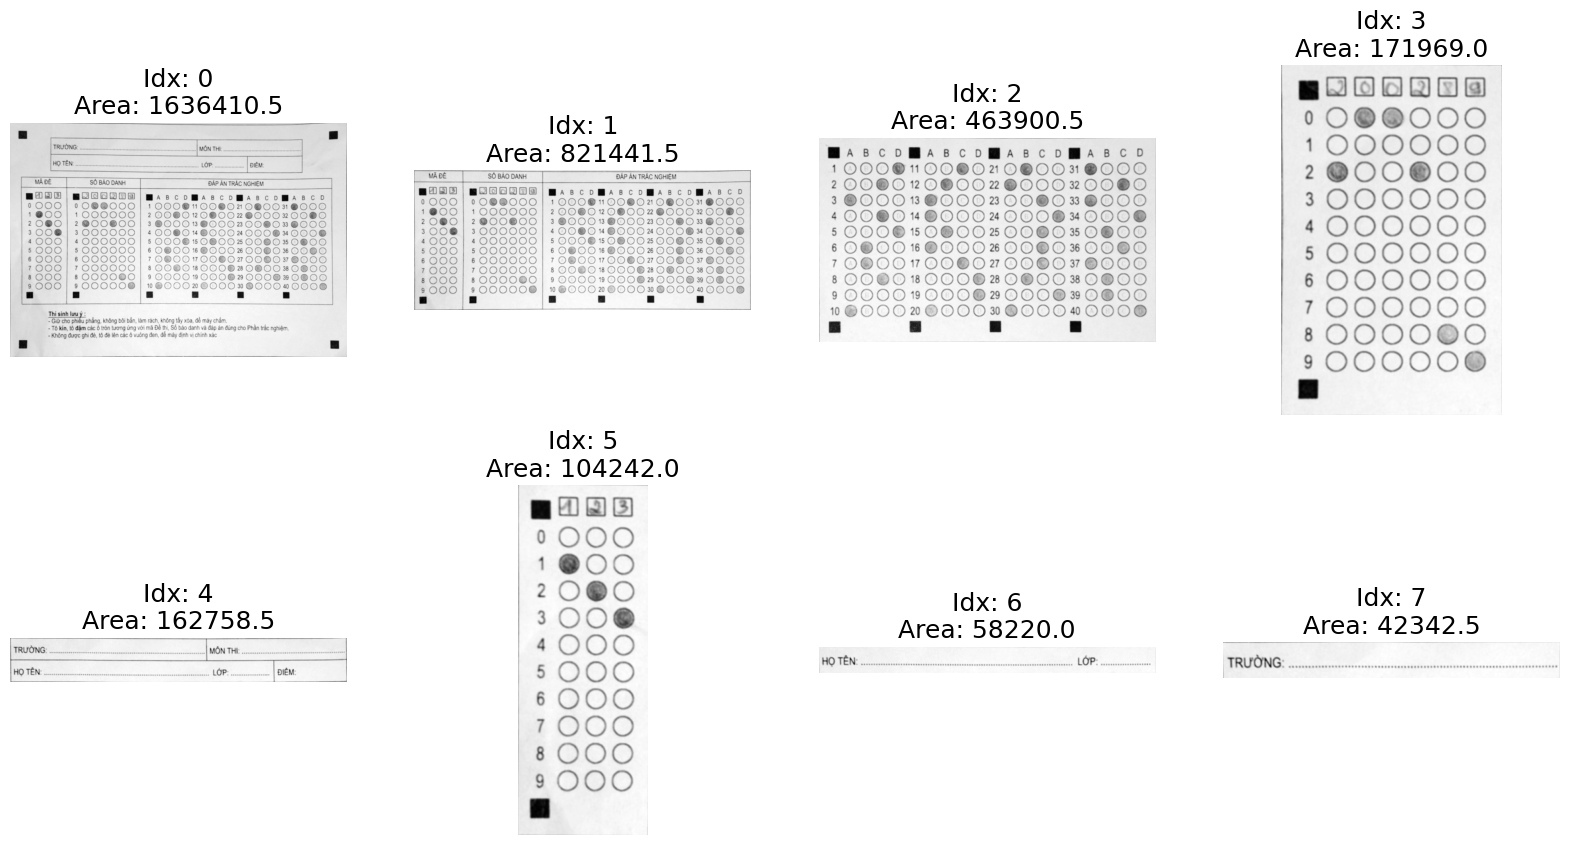

In [670]:
# 8 fig
fig, ax = plt.subplots(2, 4, figsize=(20, 10)) 
for i in range(8):
    cropped, area = crop_image_by_edge(blur, i, True)
    ax[i//4, i%4].imshow(cropped, cmap=plt.cm.gray)
    ax[i//4, i%4].axis('off')
    ax[i//4, i%4].set_title(f'Idx: {i}\nArea: {area}')
plt.show()

C:\Users\suzii\AppData\Local\Temp\ipykernel_14496\2225477519.py:19: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(cv2.boxPoints(cv2.minAreaRect(approx)))


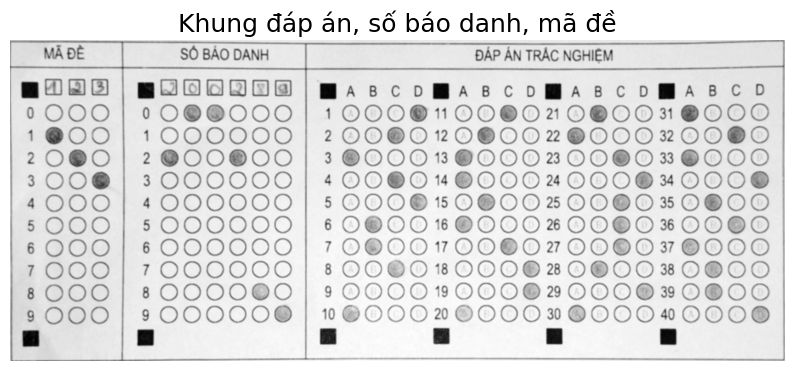

In [671]:
warped = crop_image_by_edge(blur, 1)
frames['Khung đáp án, số báo danh, mã đề'] = warped
show(warped, 'Khung đáp án, số báo danh, mã đề', True)

C:\Users\suzii\AppData\Local\Temp\ipykernel_14496\2225477519.py:19: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(cv2.boxPoints(cv2.minAreaRect(approx)))


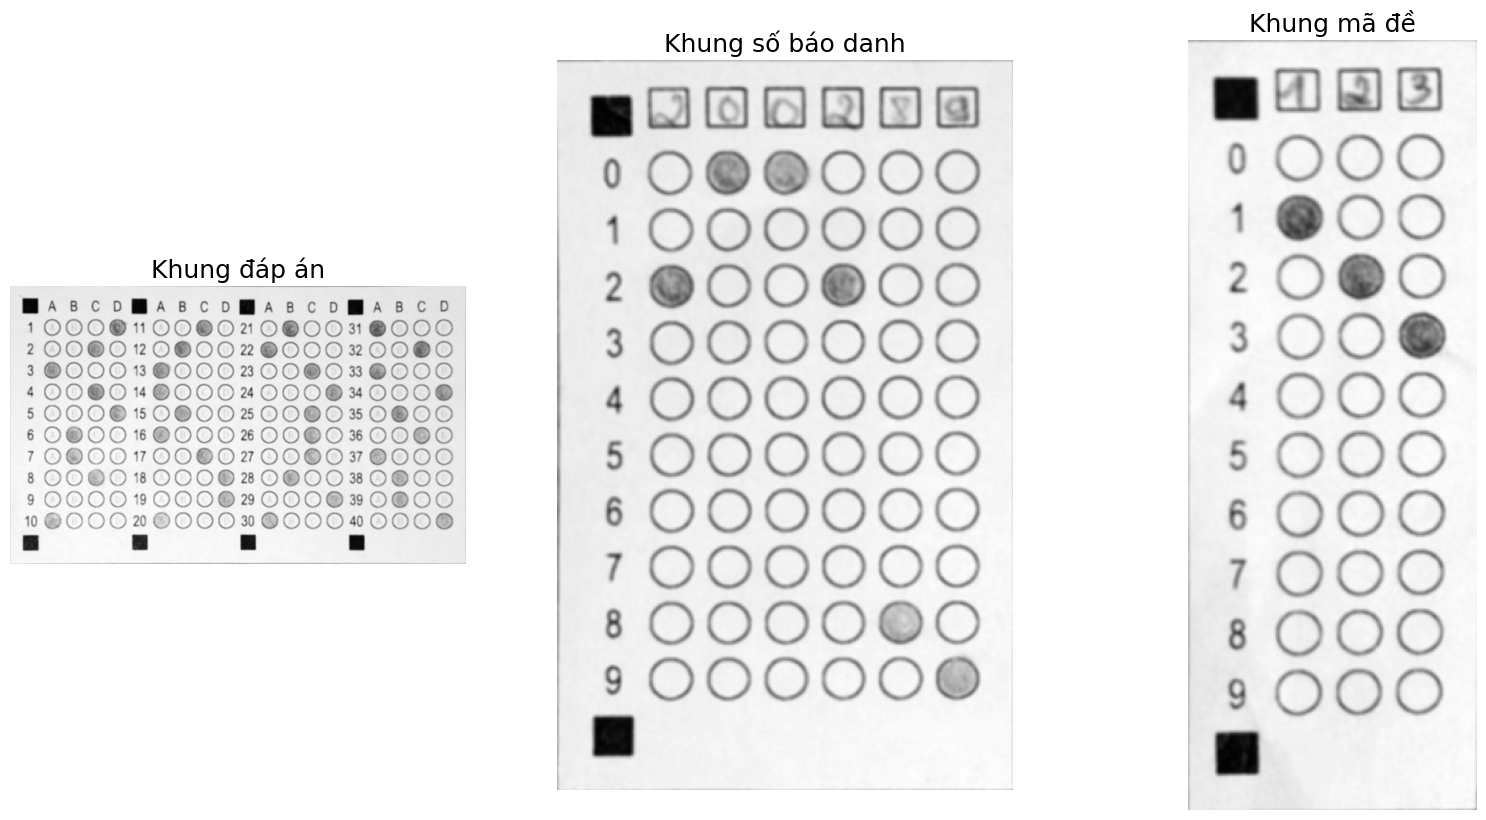

In [672]:
# 0: đáp án trắc nghiệm
# 1: số báo danh
# 2: mã đề

idx2type = {
    0: 'Khung đáp án',
    1: 'Khung số báo danh',
    2: 'Khung mã đề'
}
# fig 1x3
fig, ax = plt.subplots(1, 3, figsize=(20, 10)) 
for i in range(3):
    wr = crop_image_by_edge(warped, i)
    ax[i].imshow(wr, cmap='gray')
    frames[idx2type[i]] = wr
    ax[i].set_title(idx2type[i])
    ax[i].axis('off')

In [673]:
frames

{'Khung đáp án, số báo danh, mã đề': array([[166, 165, 165, ..., 130, 149, 166],
        [142, 137, 138, ..., 107, 128, 155],
        [115, 109, 113, ..., 106, 121, 150],
        ...,
        [166, 143, 116, ..., 101, 110, 141],
        [167, 144, 111, ..., 113, 127, 154],
        [168, 145, 108, ..., 146, 156, 171]], dtype=uint8),
 'Khung đáp án': array([[149, 158, 159, ..., 170, 169, 157],
        [171, 179, 180, ..., 181, 179, 165],
        [179, 186, 186, ..., 183, 180, 165],
        ...,
        [183, 200, 202, ..., 186, 182, 167],
        [177, 196, 199, ..., 181, 176, 160],
        [153, 171, 175, ..., 159, 153, 137]], dtype=uint8),
 'Khung số báo danh': array([[129, 130, 133, ..., 157, 154, 137],
        [163, 165, 164, ..., 180, 177, 160],
        [181, 183, 183, ..., 187, 185, 169],
        ...,
        [147, 173, 184, ..., 199, 199, 186],
        [145, 174, 185, ..., 194, 194, 180],
        [138, 167, 179, ..., 170, 170, 155]], dtype=uint8),
 'Khung mã đề': array([[129, 133,

## Tăng cường đối tượng tô đen

In [674]:
def scale_image(img, alpha, beta):
    new_img = img * alpha + beta
    new_img = np.clip(new_img, 0, 255)
    return np.uint8(new_img)

def calculate_brightness_contrast(image, clip_hist_percent):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist = hist.reshape(-1)
    cumulative_hist = np.cumsum(hist)
    total_pixels = cumulative_hist[-1]
    clip_hist_percent *= (total_pixels / 100.0)
    clip_hist_percent /= 2.0
    minimum_gray = np.argwhere(cumulative_hist > clip_hist_percent).min()
    maximum_gray = np.argwhere(cumulative_hist >= (total_pixels - clip_hist_percent)).min()

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha
    return alpha, beta

def apply_brightness_contrast_auto(image, clip_hist_percent=25):
    alpha, beta = calculate_brightness_contrast(image, clip_hist_percent)
    return scale_image(image, alpha, beta)

def remove_border(img, thresh = 10):
    h, w = img.shape
    img = img[thresh:h-thresh, thresh:w-thresh]
    return img
def increase_brightness_contrast(img, rm_bd=True):
    hist = apply_brightness_contrast_auto(img)
    threshold = (hist > 70).astype(np.uint8)*255
    
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    eroded = cv2.erode(threshold, kernel, iterations=1)
    if rm_bd:
        rm = remove_border(eroded, 10)
        return rm
    return hist


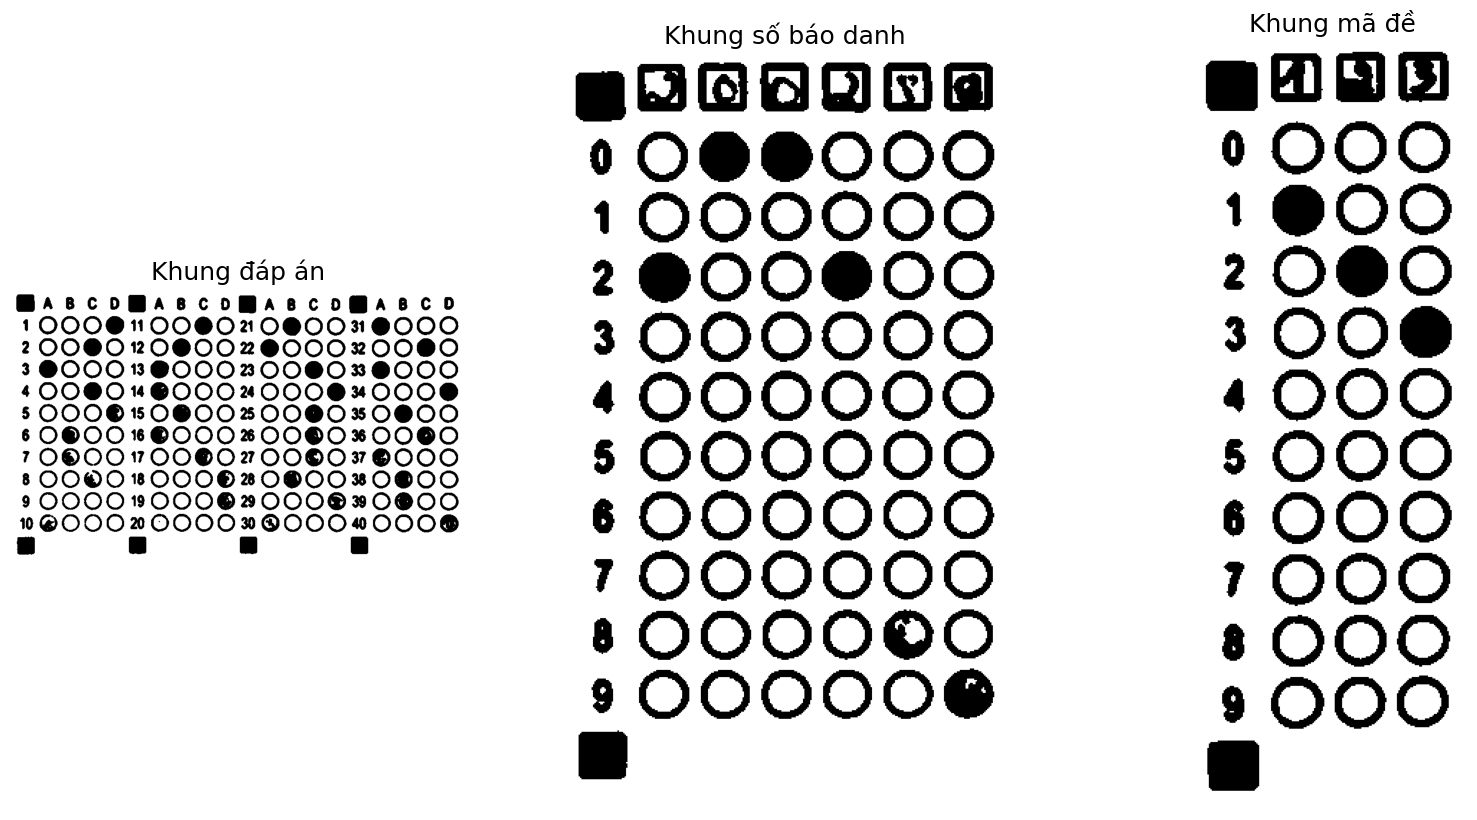

In [675]:
idx2type = {
    0: 'Khung đáp án',
    1: 'Khung số báo danh',
    2: 'Khung mã đề'
}

thresh_frames = {}

fig, ax = plt.subplots(1, 3, figsize=(20, 10)) 
for i in range(3):
    wr = increase_brightness_contrast(frames[idx2type[i]])
    ax[i].imshow(wr, cmap='gray')
    thresh_frames[idx2type[i]] = wr
    ax[i].set_title(idx2type[i])
    ax[i].axis('off')

## Detect đối tượng

In [676]:
def get_area(cnt):
    return cnt[2]*cnt[3]

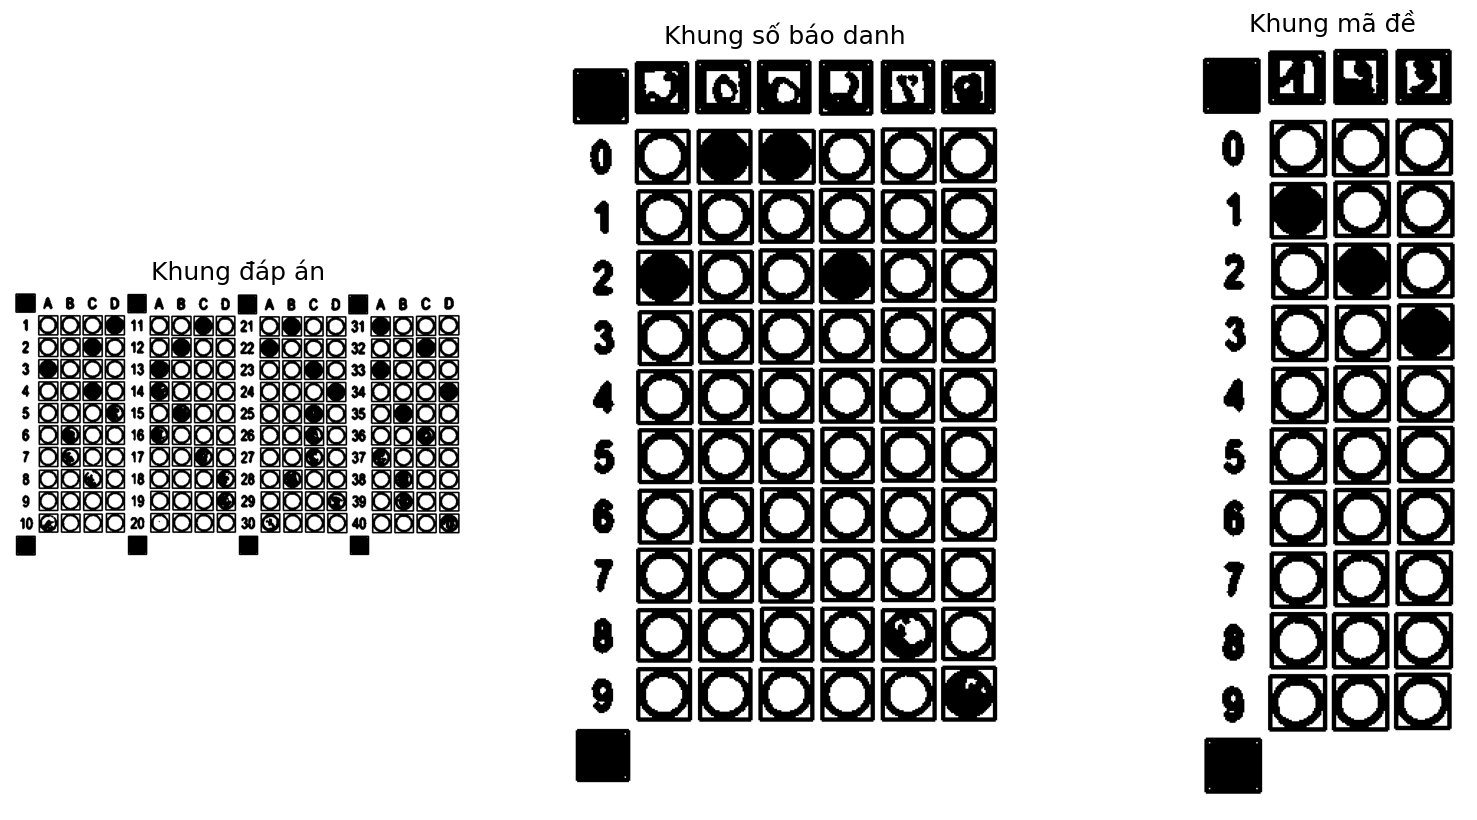

In [677]:
frame_coordinates = {}
def get_coordinates(image):
    edge = get_edges(image)
    contours = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]
    img_copy = image.copy()
    coordinates = []

    t = np.mean([get_area(cv2.boundingRect(i)) for i in contours])
    for c in contours:
        if get_area(cv2.boundingRect(c)) > t:
            x,y,w,h = cv2.boundingRect(c)
            coordinates.append((x, y, w, h))
            cv2.rectangle(img_copy,(x,y),(x+w,y+h), 0, 2)
    return coordinates, img_copy
fig, ax = plt.subplots(1, 3, figsize=(20, 10)) 
for i in range(3):
    coordinates, img_copy = get_coordinates(thresh_frames[idx2type[i]])
    frame_coordinates[idx2type[i]] = coordinates
    ax[i].imshow(img_copy, cmap='gray')
    ax[i].set_title(idx2type[i])
    ax[i].axis('off')
plt.show()

In [678]:
def check_fill(obj):
    return np.sum(np.select([obj==0, obj==1], [1, 0]))/np.sum(np.ones((obj.shape)))*100
def get_x(contour):
    return contour[0]
def get_y(contour):
    return contour[1]

def get_num(coordinates, image):
    contours_x = sorted(coordinates, key=get_x, reverse=True)
    contours_y = [sorted(contours_x[11*i:11*(i+1)], key=get_y, reverse=True) for i in range((len(contours_x)-2)//11 + 1)]
    out = [i[:10][::-1] for i in contours_y[:-1]][::-1]
    label = []
    c = []
    for i in range(len(out)):
        count = 0
        flag = 0
        for cnt in out[i]:
            col, row, w, h = cnt
            obj = image[row: row+w, col: col+h]
            if check_fill(obj) > 60:
                flag+=1
                label.append(count)
                c.append((col, row, w, h))
            count+=1
        if flag!=1:
            label.append('-')

    return ''.join(map(lambda x: str(x), label)), c

def get_predict_answer(coordinates, image):
    contours_x = sorted(coordinates, key=get_y, reverse=True)[4:-4]
    contours_y = [sorted(contours_x[16*i: 16*(i+1)], key=get_x) for i in range(10)]
    out = contours_y[::-1]
    label = {1: 'A', 2: 'B', 3: 'C', 4: 'D'}
    predict = {}
    cnt_tmp = {}
    for idx, r in enumerate(out,1):
        for k in range(4):
            flag = 0
            c = ()
            prb = [r[4*i: 4*(i+1)] for i in range(4)]
            answer_pred = 0
            for count, cnt in enumerate(prb[k],1):
                col, row, w, h = cnt
                obj = image[row: row+w, col: col+h]
                if check_fill(obj) > 52:
                    flag+=1
                    c = (col, row, w, h)
                    answer_pred = count                
            if flag == 1:
                predict[k*10+idx] = label[answer_pred]
                cnt_tmp[k*10+idx] = c
            else:
                cnt_tmp[k*10+idx] = None
                predict[k*10+idx] = '-'
    return predict, cnt_tmp

def get_score(result, predict):
    score = 0
    for i in range(1,41):
        if result[str(i)] == predict[i]:
            score+=1
    return score*0.25


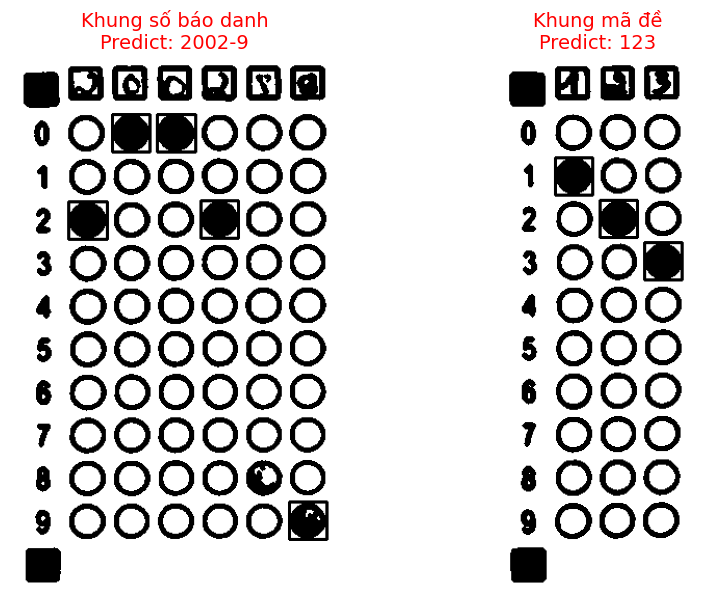

In [679]:
f = ['Khung số báo danh', 'Khung mã đề']
info = {}
fig, ax = plt.subplots(1, 2, figsize=(10, 7))
for i in range(2):
    coordinates = frame_coordinates[f[i]]
    image = thresh_frames[f[i]]
    label, cnt = get_num(coordinates, image)
    info[f[i]] = label
    for c in cnt:
        col, row, w, h = c
        cv2.rectangle(image,(col,row),(col+w,row+h), 0, 2)
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title(f'{f[i]}\nPredict: {label}', fontsize=14, color='red')
    ax[i].axis('off')
plt.show()

In [680]:
import json
with open('{}.json'.format(info['Khung mã đề'])) as f:
    result = json.load(f)

predict, cnt = get_predict_answer(frame_coordinates['Khung đáp án'].copy(), thresh_frames['Khung đáp án'])
score = get_score(result, predict)

In [681]:
# cvt gray 2 bgr
def cvt2bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

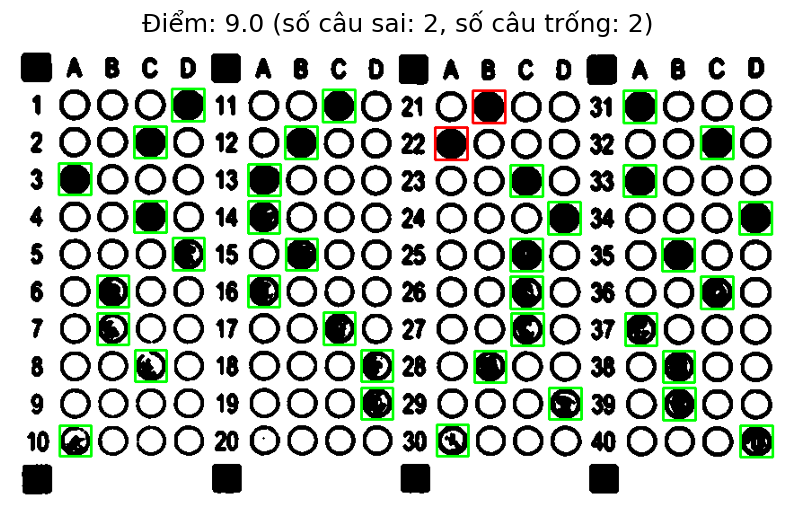

In [682]:
# vẽ câu nào đúng thì khung màu xanh, sai khung màu đỏ
def draw_answer(img, cnt, result, predict):
    num_none = 0
    num_fail = 0
    for i in range(len(cnt)):
        if cnt[i+1] is None:
            num_none+=1
            continue
        col, row, w, h = cnt[i+1]
        if result[str(i+1)] == predict[i+1]:
            cv2.rectangle(img, (col, row), (col+w, row+h), (0, 255, 0), 2)
        else:
            num_fail+=1
            cv2.rectangle(img, (col, row), (col+w, row+h), (0, 0, 255), 2)
    return img, num_fail, num_none
img, num_fail, num_none = draw_answer(cvt2bgr(thresh_frames['Khung đáp án'].copy()), cnt, result, predict)
show(img, f'Điểm: {score} (số câu sai: {num_fail}, số câu trống: {num_none})')

## Finaly

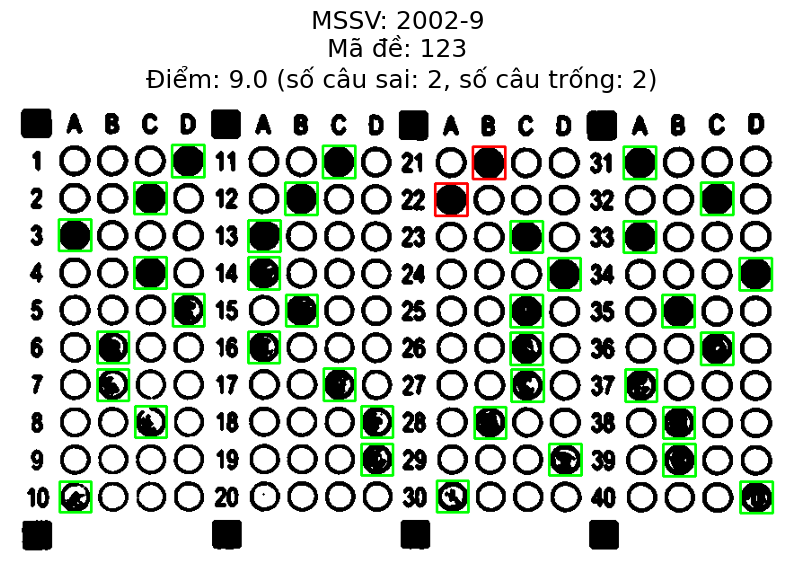

In [683]:
made = info['Khung mã đề']
mssv = info['Khung số báo danh']
show(img, f'MSSV: {mssv}\nMã đề: {made}\n Điểm: {score} (số câu sai: {num_fail}, số câu trống: {num_none})')